# Testing the Linear Model trained in TensorFlow 

In [1]:
from __future__ import print_function
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
from math import acos
import numpy as np
import matplotlib.pyplot as plt
from link_bot_notebooks.linear_tf_model import LinearTFModel

importing Jupyter notebook from /home/pmitrano/catkin_ws/src/link_bot/link_bot_notebooks/src/link_bot_notebooks/toy_problem_optimization_common.ipynb


In [2]:
goal = np.array([[0], [0], [1], [0], [2], [0]])
args = {'checkpoint': "log_data/November_26_22:57:12/nn.ckpt-50000", 'log': False}
dataset = "../../../link_bot_teleop/data/2_link_pos_and_vel_2.txt"
n, x, y = tpo.load_train_test(dataset, N=6, M=2, L=2, g=goal, extract_func=tpo.two_link_pos_vel_extractor)
model = LinearTFModel(args, N=6, M=2, L=2)
model.load()

INFO:tensorflow:Restoring parameters from log_data/November_26_22:57:12/nn.ckpt-50000
Restored ckpt log_data/November_26_22:57:12/nn.ckpt-50000 at step 50000


In [3]:
A, B, C, D, c_loss, sp_loss, cp_loss, reg, loss = model.evaluate(x, y, display=True)

Cost Loss: 0.00241501396522
State Prediction Loss: 7.22260374459e-05
Cost Prediction Loss: 0.00416959775612
Regularization: 0.000230321951676
Overall Loss: 0.00688715977594
A:
[[ 1.35 -0.79  0.04 -0.01 -0.02  0.  ]
 [-0.64 -1.01 -0.01  0.    0.    0.  ]]
B:
[[-0.  0.]
 [-0.  0.]]
C:
[[ 0.12 -0.09]
 [-0.08 -0.11]]
D:
[[ 0.39 -0.11]
 [ 0.15  0.7 ]]


In [4]:
def angle(v1, v2):
    return np.rad2deg(acos(np.dot(v1, v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))))
print(angle(A[0, 0:2], A[1, 0:2]))

91.84199583054567


In [5]:
data = tpo.load_data(dataset, g=goal, extract_func=tpo.two_link_pos_vel_extractor)
print(data[0])

[array([[-4.],
       [-2.],
       [-3.],
       [-2.],
       [-2.],
       [-2.]]), array([[-0.],
       [-0.]]), array([[-4.],
       [-2.],
       [-3.],
       [-2.],
       [-2.],
       [-2.]]), array([20.]), array([20.])]


min cost 0.009813649


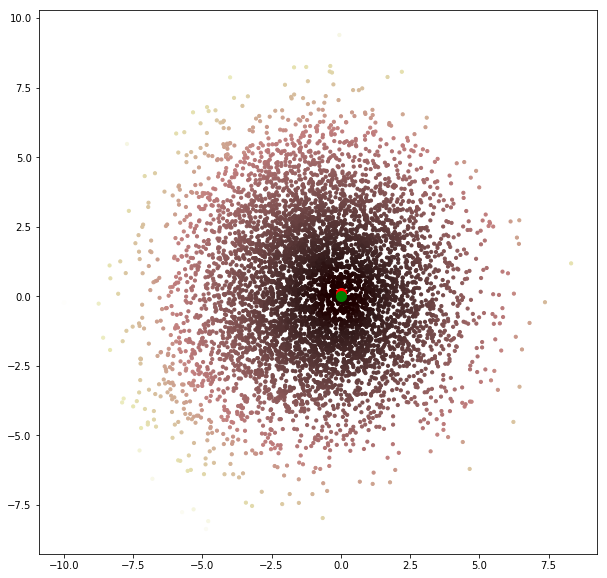

In [6]:
# tpo.plot_costmap(plt, model, data, goal, samples=100, spread=0.4)
min_sample, min_cost = tpo.plot_costmap(plt, model, data, goal, samples=10, spread=2)
print("min cost", min_cost)
plt.scatter([min_sample[0]], [min_sample[1]], s=100, c='Red', label='min sample');
plt.scatter(goal[0], goal[1], s=100, c='Green', label='goal');

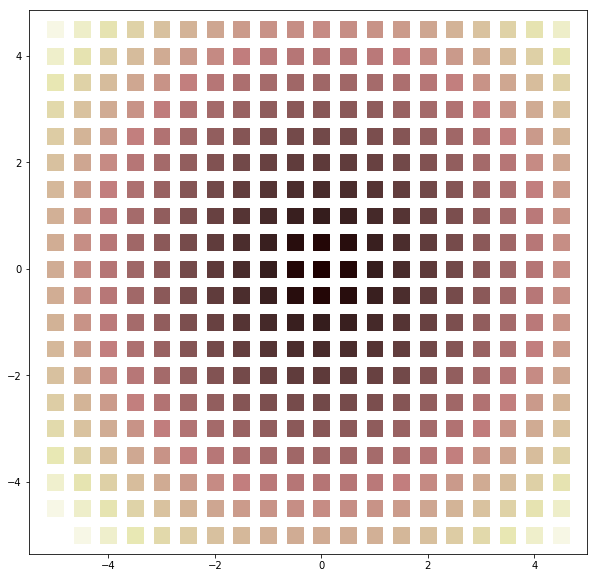

In [7]:
def plot_costmap_2(plt, model, data, g, resolution=0.1, minimum=-5, maximum=5):
    colors = {}
    N = (maximum - minimum) / resolution
    min_sample = None
    min_sample_cost = 1e9
    for x in np.arange(minimum, maximum, resolution):
        for y in np.arange(minimum, maximum, resolution):
            for theta in np.arange(-np.pi, np.pi, np.pi/4):
                s = np.array([[x], [y], [x+np.cos(theta)], [y+np.sin(theta)], [x+2*np.cos(theta)], [y+2*np.sin(theta)]])
                c = model.cost_of_s(s, g)[0,0]
                xy = (x,y)
                colors[xy] = c
                if c < min_sample_cost:
                    min_sample_cost = c
                    min_sample = s
            
    plt.figure(figsize=(10,10))
    xs = [k[0] for k in colors.keys()]
    ys = [k[1] for k in colors.keys()]
    plt.scatter(xs, ys, c=colors.values(), s=resolution * 500, cmap='pink', marker='s')
    plt.axis("equal")
    return min_sample, min_sample_cost

tpo.plot_costmap_2(plt, model, data, goal, resolution=.5, minimum=-5, maximum=5);

In [8]:
s0 = np.array([[-1], [0], [0], [0], [1], [0]])

In [9]:
o0 = model.reduce(s0)
print(o0)

[[-1.38]
 [ 0.64]]


In [10]:
u, c, next_o = model.act(o0, goal)
print("action", u)
print("cost before action", c)
print("next state in latent space", next_o)

action [[10.41]
 [-1.36]]
cost before action [0.]
next state in latent space [[-0.]
 [-0.]]


TypeError: data type not understood

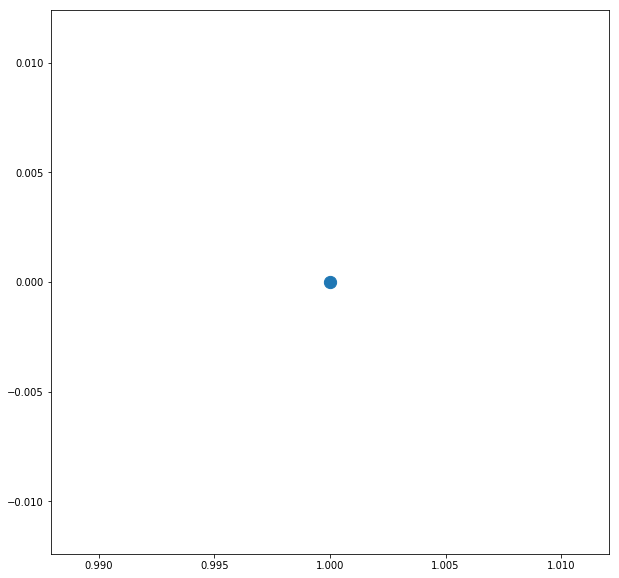

In [12]:
points = np.array([[1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])
R = model.A[:2]
new_points = []
for p in points:
    new_p = np.dot(R, p)
    new_points.append(new_p)
new_points = np.array(new_points)
    
plt.figure(figsize=(10,10))
plt.scatter([points[0,0]], [points[0,1]], s=150)
plt.scatter([new_points[0,0]], [new_points[0,1]], s=150)
plt.scatter([p[0] for p in points], [p[1] for p in points])
plt.scatter([p[0] for p in new_points], [p[1] for p in new_points])
plt.plot([p[0] for p in points], [p[1] for p in points], label='original')
plt.plot([p[0] for p in new_points], [p[1] for p in new_points], label='latent')
plt.legend()
plt.axis("equal")

In [13]:
back_s = np.linalg.lstsq(A, o0, rcond=None)[0]
print(s0)
print(back_s)

[[-1]
 [ 0]
 [ 0]
 [ 0]
 [ 1]
 [ 0]]
[[-1.01]
 [ 0.01]
 [-0.02]
 [ 0.01]
 [ 0.01]
 [-0.  ]]


In [14]:
next_o = model.predict(o0, np.array([[10], [0]]))
print(next_o)

[[-0.17]
 [-0.13]]


In [15]:
back_s = np.linalg.lstsq(A, next_o, rcond=None)[0]
print(back_s)

[[-0.04]
 [ 0.15]
 [-0.  ]
 [ 0.  ]
 [ 0.  ]
 [-0.  ]]


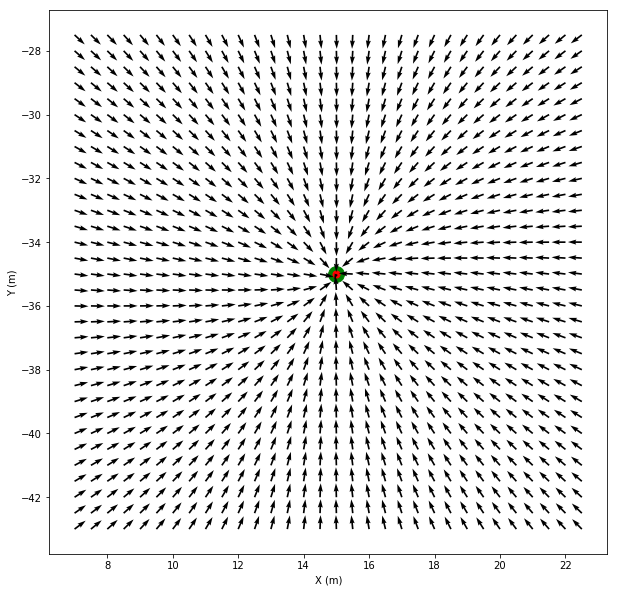

In [34]:
r = 0.5
cx = 15
cy = -35
m = 8
x = []
y = []
u = []
v = []
goal = np.array([[cx], [cy], [0], [0], [0], [0]])
min_a = 1e9 * np.ones((2, 1))
min_a_x = None
min_a_y = None
og = model.reduce(goal)
for s1 in np.arange(cx-m, cx+m, r):
    for s2 in np.arange(cy-m, cy+m, r):
        o = model.reduce(np.array([[s1], [s2], [0], [0], [0], [0]]))
        o1 = o[0, 0]
        o2 = o[1, 0]
        full_a, full_c, next_o = model.act(o, goal)
        if np.linalg.norm(full_a) > 1.00:
            a = full_a / np.linalg.norm(full_a) * 1.00  # a is in meters per second. Cap to 0.75
        else:
            a = full_a

        x.append(s1)
        y.append(s2)
        u.append(a[0, 0])
        v.append(a[1, 0])
        if np.linalg.norm(a) < np.linalg.norm(min_a):
            min_a = a
            min_a_x = s1
            min_a_y = s2
        
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.scatter(goal[0, 0], goal[1, 0], s=250, c='g')
ax.scatter(min_a_x, min_a_y, s=50, c='r')
q = ax.quiver(x, y, u, v, scale=40, width=0.003)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)");

In [19]:
print(np.linalg.norm(min_a - goal[0:2]))

37.790660808161306


In [45]:
a = A[:2,:2]
print(a, '\n')
print(C, '\n')
print(a*0.1, '\n')
print(a / C)

[[ 1.35 -0.79]
 [-0.64 -1.01]] 

[[ 0.12 -0.09]
 [-0.08 -0.11]] 

[[ 0.14 -0.08]
 [-0.06 -0.1 ]] 

[[11.27  9.3 ]
 [ 8.27  8.79]]
